# Import libraries

In [54]:
import os
import sys

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import numpy as np
import pandas as pd  # Import Pandas and Numpy to create databases
import tensorflow as tf  # Import tensorflow to do tensor manipulations

from abyss.glob import glob
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
import matplotlib.pyplot as plt
import seaborn as sns

In [55]:
phenotypes_labels = {
    "bc": "Breast Cancer",
    "cad": "Coronary Artery Disease",
    "ms": "Multiple Sclerosis",
    "t2d": "Type 2 Diabetes",
    "pc": "Prostate Cancer",
    "ibd": "Inflammatory Bowel Disease"
}

scenario_labels = {
    "no_cov": "no covariates",
    "abyss": "Abyss correction",
    "cov": "PCA correction",
    "abyss_cov": "Abyss + PCA as covariates"
}
def rename_duplicates(df):
    cols = pd.Series(df.columns)
    for dup in cols[cols.duplicated()].unique():
        print(dup)
        cols[cols[cols == dup].index.values.tolist()] = [dup + '_' + str(i) if i != 0 else dup for i in range(sum(cols == dup))]
    df.columns = cols
    return df

In [56]:
pheno_name = "bc"

In [57]:
path_pheno = f"../data_ignored/UKBiobank/phenotype"
path_geno = f"../data_ignored/UKBiobank/genotype"
path_usefull = f"../data_ignored/UKBiobank/usefull_values"

In [58]:
pheno = pd.read_pickle(f"{path_pheno}/{pheno_name}.pkl")

In [59]:
pheno

,FID,IID,phenotype
0,5568535,5568535,1
1,3655942,3655942,1
2,5439742,5439742,0
3,2880492,2880492,0
4,2164377,2164377,1
...,...,...,...
12913,1069957,1069957,1
12914,4188122,4188122,0
12915,5894824,5894824,0
12916,3829752,3829752,0


In [60]:
id_samples = pd.read_pickle(f"{path_usefull}/id_samples.pkl")

In [61]:
path_mafs = f"{path_geno}/08_MAF_probability_landscape/{pheno_name}/bin_12/1_bottleneck_dims"

In [62]:
snps = []
consts = []
effect_size_snps = []
std_errs = []
ts = []
Ps = []
    
for maf_probs in os.listdir(path_mafs):
    path_maf_file = path_mafs + "/" + maf_probs
    mafprob = pd.read_pickle(path_maf_file)
    mafprob['FID'] = id_samples['FID']
    mafprob = pd.merge(mafprob, pheno[['FID','phenotype']], on='FID')
    filtered_columns = [col for col in mafprob.columns if col not in ['FID', 'phenotype']]
    for snp_id in filtered_columns:
        snps.append(snp_id)
        X = mafprob[[snp_id]]
        X2 = sm.add_constant(X)
        est = sm.OLS(mafprob[['phenotype']], X2)
        est2 = est.fit()
        # Extract coefficients (betas)
        betas = est2.params            
        try:
            consts.append(betas['const'])
        except:
            consts.append(0)
        effect_size_snps.append(betas[snp_id])
        std_errs.append(est2.bse[snp_id])
        ts.append(est2.tvalues[snp_id])
                
        P = est2.pvalues[snp_id]
        Ps.append(P)
        
sumstat_maf_prob = pd.DataFrame(data={
    'snp': snps,
    'consts': consts,
    'beta_snp': effect_size_snps,
    'std_err': std_errs,
    'Z': ts,
    'P': Ps
    })
try:
    split_data = sumstat_maf_prob['snp'].str.split(':', expand=True)
    chromosome = split_data[0]
    position = split_data[1]
    sumstat_maf_prob['#CHROM'] = chromosome.astype(int)
    sumstat_maf_prob['POS'] = position.astype(int)
    sumstat_maf_prob['POS'] = sumstat_maf_prob['POS'].astype(int)
    sumstat_maf_prob['-logp'] = - np.log(sumstat_maf_prob['P'])
except:
    print("there is something weird")

In [63]:
sumstat_maf_prob

,snp,consts,beta_snp,std_err,Z,P,#CHROM,POS,-logp
0,1:5572304:A_G_G,0.394202,0.129366,3.657630,0.035369,0.971786,1,5572304,0.028619
1,1:9234363:G_T_G,0.478731,0.025808,1.902014,0.013569,0.989174,1,9234363,0.010885
2,1:13844765:A_G_G,0.495700,0.005192,1.299445,0.003996,0.996812,1,13844765,0.003193
3,1:18022066:G_T_T,0.215579,0.347127,5.242636,0.066212,0.947210,1,18022066,0.054235
4,1:40976258:C_T_T,0.457021,0.052147,2.634794,0.019792,0.984210,1,40976258,0.015916
...,...,...,...,...,...,...,...,...,...
1345,16:60915814:G_T_G,-1.803411,2.827337,11.390401,0.248221,0.803967,16,60915814,0.218197
1346,16:62967153:A_G_A,-1.833120,2.891526,13.304599,0.217333,0.827952,16,62967153,0.188800
1347,16:82746350:C_T_C,0.188723,0.384191,4.906370,0.078305,0.937587,16,82746350,0.064446
1348,16:86336812:C_T_C,-27.486869,34.509878,42.496398,0.812066,0.416769,16,86336812,0.875224


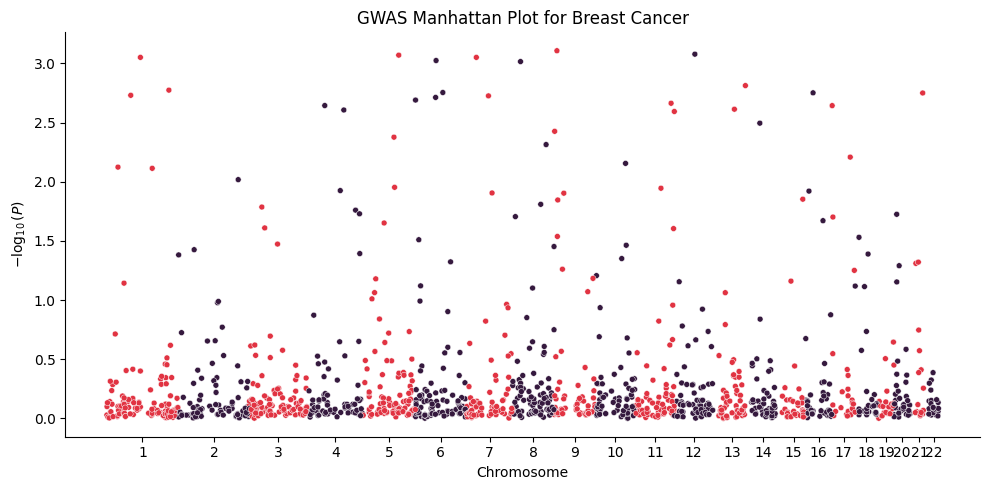

In [64]:
running_pos = 0
cumulative_pos = []
for chrom, group_df in sumstat_maf_prob.groupby('#CHROM'):
    cumulative_pos.append(group_df['POS'] + running_pos)
    running_pos += group_df['POS'].max()

sumstat_maf_prob['cumulative_pos'] = pd.concat(cumulative_pos)
sumstat_maf_prob['SNP number'] = sumstat_maf_prob.index

# Define two contrasting colors from the rocket palette
palette = sns.color_palette("rocket", as_cmap=False)
color1 = palette[3]  # First color of the palette
color2 = palette[0] # Last color of the palette, for maximum contrast

# Function to assign color based on chromosome
def assign_color(chrom_number):
    return color1 if chrom_number % 2 == 0 else color2

# Apply the function to create a color column
sumstat_maf_prob['color'] = sumstat_maf_prob['#CHROM'].apply(assign_color)

chrom_midpoints = []
for chrom, group_df in sumstat_maf_prob.groupby('#CHROM'):
    midpoint = group_df['cumulative_pos'].min() + (group_df['cumulative_pos'].max() - group_df['cumulative_pos'].min()) / 2
    chrom_midpoints.append(midpoint)

# Plotting
g = sns.relplot(
    data=sumstat_maf_prob,
    x='cumulative_pos',
    y='-logp',
    aspect=2,
    hue='color',
    palette=[color1, color2],
    legend=False,
    size=3 
)


# Set x-axis ticks and labels with reversed chromosome order
chrom_labels = np.sort(sumstat_maf_prob['#CHROM'].unique()) # Reversing the order of chromosomes

# Set the title and x-axis, y-axis labels
g.set(title=f"GWAS Manhattan Plot for {phenotypes_labels[pheno_name]}")
g.set(xticks=chrom_midpoints, xticklabels=chrom_labels)
g.set_axis_labels("Chromosome", r"$-\log_{10}(P)$")  # Set y-axis label with subscript

# Set the tick labels at a 45-degree angle
for ax in g.axes.flat:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

# Optional: Improve the layout
plt.tight_layout()

plt.show()

# Classical GWAS (no corr)

In [65]:
path_files = f"{path_geno}/04_LD_blocks/15_PCs/bin_12/"

In [66]:
snps = []
consts = []
effect_size_snps = []
effect_size_mafs = []
std_errs = []
ts = []
Ps = []
for file in os.listdir(path_files):
    path_file = path_files + file
    genos = pd.read_pickle(path_file)
    scaled_data = scaler.fit_transform(genos)
    genos = pd.DataFrame(scaled_data, columns=genos.columns)
    genos = rename_duplicates(genos)
    genos['FID'] = id_samples['FID']
    genos = pd.merge(genos, pheno[['FID','phenotype']], on='FID')
    filtered_columns = [col for col in genos.columns if col not in ['FID', 'phenotype']]
    for snp_id in filtered_columns:
        snps.append(snp_id)
        # Concatenate genotype and MAF probability data for the SNP
        X = genos[[snp_id]]
        X2 = sm.add_constant(X)
        # Perform OLS regression
        est = sm.OLS(genos[['phenotype']], X2)
        est2 = est.fit()
        # Extract coefficients (betas)
        betas = est2.params
        try:
            consts.append(betas['const'])
        except:
            consts.append(0)
        effect_size_snps.append(betas[snp_id])
        std_errs.append(est2.bse[snp_id])
        ts.append(est2.tvalues[snp_id])
            
        P = est2.pvalues[snp_id]
        Ps.append(P)
    
sumstat = pd.DataFrame(data={
'snp': snps,
'consts': consts,
'beta_snp': effect_size_snps,
'std_err': std_errs,
'Z': ts,
'P': Ps
})
try:
    split_data = sumstat['snp'].str.split(':', expand=True)
    chromosome = split_data[0]
    position = split_data[1]
    sumstat['#CHROM'] = chromosome.astype(int)
    sumstat['POS'] = position.astype(int)
    sumstat['POS'] = sumstat['POS'].astype(int)
    sumstat['-logp'] = - np.log(sumstat['P']+ 1e-10)
except:
    print("there is something weird")

In [67]:
sumstat

,snp,consts,beta_snp,std_err,Z,P,#CHROM,POS,-logp
0,1:5572304:A_G_G,0.499993,0.000726,0.004431,0.163874,0.869833,1,5572304,0.139454
1,1:9234363:G_T_G,0.500035,0.004748,0.004392,1.081015,0.279711,1,9234363,1.273999
2,1:13844765:A_G_G,0.500004,0.001885,0.004414,0.427070,0.669336,1,13844765,0.401469
3,1:18022066:G_T_T,0.500001,0.000283,0.004382,0.064583,0.948507,1,18022066,0.052866
4,1:40976258:C_T_T,0.500003,-0.003777,0.004434,-0.851748,0.394370,1,40976258,0.930467
...,...,...,...,...,...,...,...,...,...
1345,16:60915814:G_T_G,0.499997,0.000288,0.004450,0.064699,0.948415,16,60915814,0.052964
1346,16:62967153:A_G_A,0.500051,0.005168,0.004376,1.181148,0.237566,16,62967153,1.437310
1347,16:82746350:C_T_C,0.500022,0.003838,0.004370,0.878214,0.379844,16,82746350,0.967995
1348,16:86336812:C_T_C,0.499975,0.007633,0.004428,1.723774,0.084772,16,86336812,2.467784


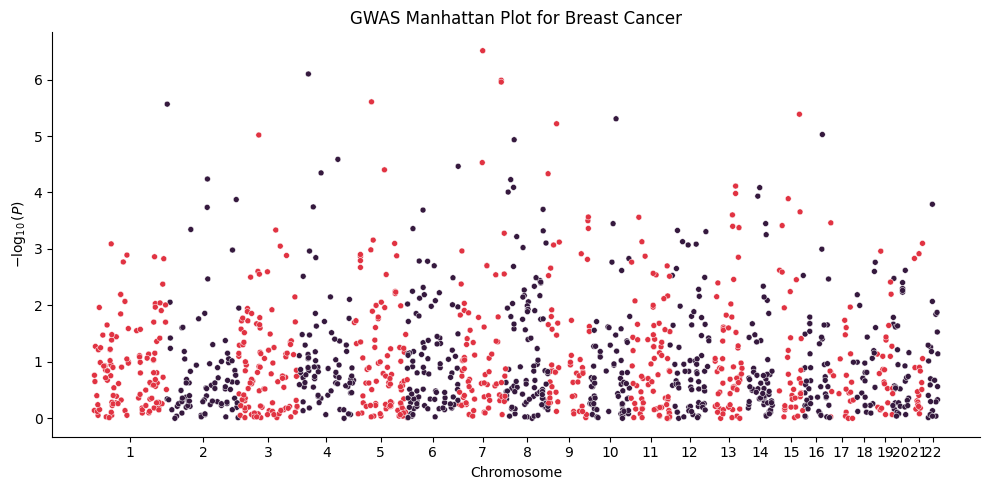

In [68]:
running_pos = 0
cumulative_pos = []
for chrom, group_df in sumstat.groupby('#CHROM'):
    cumulative_pos.append(group_df['POS'] + running_pos)
    running_pos += group_df['POS'].max()

sumstat['cumulative_pos'] = pd.concat(cumulative_pos)
sumstat['SNP number'] = sumstat.index

# Define two contrasting colors from the rocket palette
palette = sns.color_palette("rocket", as_cmap=False)
color1 = palette[3]  # First color of the palette
color2 = palette[0] # Last color of the palette, for maximum contrast

# Function to assign color based on chromosome
def assign_color(chrom_number):
    return color1 if chrom_number % 2 == 0 else color2

# Apply the function to create a color column
sumstat['color'] = sumstat['#CHROM'].apply(assign_color)

chrom_midpoints = []
for chrom, group_df in sumstat.groupby('#CHROM'):
    midpoint = group_df['cumulative_pos'].min() + (group_df['cumulative_pos'].max() - group_df['cumulative_pos'].min()) / 2
    chrom_midpoints.append(midpoint)

# Plotting
g = sns.relplot(
    data=sumstat,
    x='cumulative_pos',
    y='-logp',
    aspect=2,
    hue='color',
    palette=[color1, color2],
    legend=False,
    size=3 
)


# Set x-axis ticks and labels with reversed chromosome order
chrom_labels = np.sort(sumstat['#CHROM'].unique()) # Reversing the order of chromosomes

# Set the title and x-axis, y-axis labels
g.set(title=f"GWAS Manhattan Plot for {phenotypes_labels[pheno_name]}")
g.set(xticks=chrom_midpoints, xticklabels=chrom_labels)
g.set_axis_labels("Chromosome", r"$-\log_{10}(P)$")  # Set y-axis label with subscript

# Set the tick labels at a 45-degree angle
for ax in g.axes.flat:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

# Optional: Improve the layout
plt.tight_layout()

plt.show()

In [69]:
sumstat["-logp_test"] = sumstat["-logp"] -sumstat_maf_prob["-logp"]

In [70]:
sumstat

,snp,consts,beta_snp,std_err,Z,P,#CHROM,POS,-logp,cumulative_pos,SNP number,color,-logp_test
0,1:5572304:A_G_G,0.499993,0.000726,0.004431,0.163874,0.869833,1,5572304,0.139454,5572304,0,"(0.20973515, 0.09747934, 0.24238489)",0.110835
1,1:9234363:G_T_G,0.500035,0.004748,0.004392,1.081015,0.279711,1,9234363,1.273999,9234363,1,"(0.20973515, 0.09747934, 0.24238489)",1.263114
2,1:13844765:A_G_G,0.500004,0.001885,0.004414,0.427070,0.669336,1,13844765,0.401469,13844765,2,"(0.20973515, 0.09747934, 0.24238489)",0.398276
3,1:18022066:G_T_T,0.500001,0.000283,0.004382,0.064583,0.948507,1,18022066,0.052866,18022066,3,"(0.20973515, 0.09747934, 0.24238489)",-0.001368
4,1:40976258:C_T_T,0.500003,-0.003777,0.004434,-0.851748,0.394370,1,40976258,0.930467,40976258,4,"(0.20973515, 0.09747934, 0.24238489)",0.914550
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1345,16:60915814:G_T_G,0.499997,0.000288,0.004450,0.064699,0.948415,16,60915814,0.052964,2437719920,1345,"(0.8833417, 0.19830556, 0.26014181)",-0.165233
1346,16:62967153:A_G_A,0.500051,0.005168,0.004376,1.181148,0.237566,16,62967153,1.437310,2439771259,1346,"(0.8833417, 0.19830556, 0.26014181)",1.248511
1347,16:82746350:C_T_C,0.500022,0.003838,0.004370,0.878214,0.379844,16,82746350,0.967995,2459550456,1347,"(0.8833417, 0.19830556, 0.26014181)",0.903549
1348,16:86336812:C_T_C,0.499975,0.007633,0.004428,1.723774,0.084772,16,86336812,2.467784,2463140918,1348,"(0.8833417, 0.19830556, 0.26014181)",1.592560


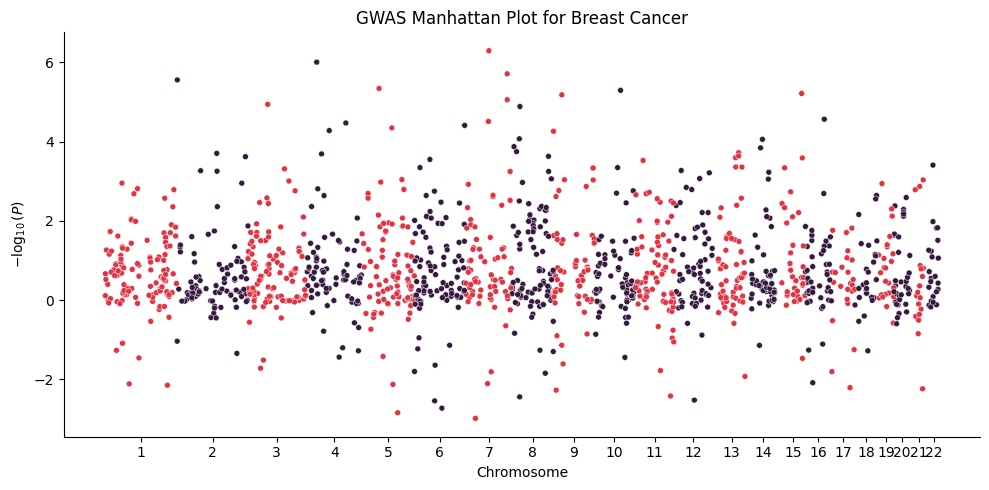

In [71]:
running_pos = 0
cumulative_pos = []
for chrom, group_df in sumstat.groupby('#CHROM'):
    cumulative_pos.append(group_df['POS'] + running_pos)
    running_pos += group_df['POS'].max()

sumstat['cumulative_pos'] = pd.concat(cumulative_pos)
sumstat['SNP number'] = sumstat.index

# Define two contrasting colors from the rocket palette
palette = sns.color_palette("rocket", as_cmap=False)
color1 = palette[3]  # First color of the palette
color2 = palette[0] # Last color of the palette, for maximum contrast

# Function to assign color based on chromosome
def assign_color(chrom_number):
    return color1 if chrom_number % 2 == 0 else color2

# Apply the function to create a color column
sumstat['color'] = sumstat['#CHROM'].apply(assign_color)

chrom_midpoints = []
for chrom, group_df in sumstat.groupby('#CHROM'):
    midpoint = group_df['cumulative_pos'].min() + (group_df['cumulative_pos'].max() - group_df['cumulative_pos'].min()) / 2
    chrom_midpoints.append(midpoint)

# Plotting
g = sns.relplot(
    data=sumstat,
    x='cumulative_pos',
    y='-logp_test',
    aspect=2,
    hue='color',
    palette=[color1, color2],
    legend=False,
    size=3 
)


# Set x-axis ticks and labels with reversed chromosome order
chrom_labels = np.sort(sumstat['#CHROM'].unique()) # Reversing the order of chromosomes

# Set the title and x-axis, y-axis labels
g.set(title=f"GWAS Manhattan Plot for {phenotypes_labels[pheno_name]}")
g.set(xticks=chrom_midpoints, xticklabels=chrom_labels)
g.set_axis_labels("Chromosome", r"$-\log_{10}(P)$")  # Set y-axis label with subscript

# Set the tick labels at a 45-degree angle
for ax in g.axes.flat:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

# Optional: Improve the layout
plt.tight_layout()

plt.show()

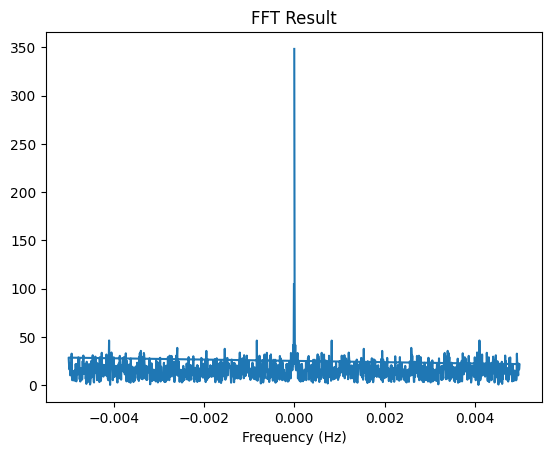

In [72]:
  import matplotlib.pyplot as plt

# Sample data - replace this with your own data
# Here, we create a sine wave as an example
fs = 0.01  # Sampling frequency (Hz)

# Perform the FFT
fft_result = np.fft.fft(np.array(sumstat_maf_prob["-logp"]))
frequencies = np.fft.fftfreq(len(fft_result), 1/fs)

# Plot the FFT result


plt.plot(frequencies, abs(fft_result))
plt.title('FFT Result')
plt.xlabel('Frequency (Hz)')

plt.show()

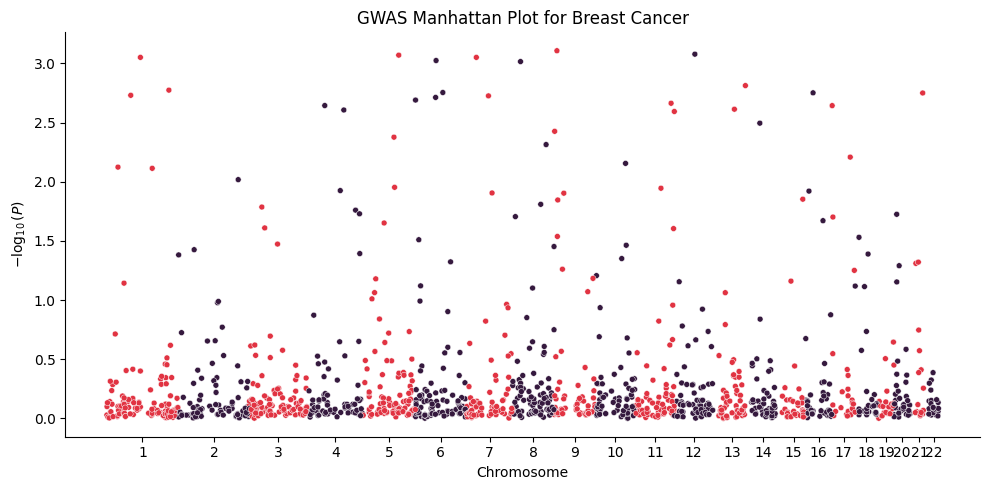

In [77]:
# Sample data - replace this with your own data
# Assuming you have already defined fs and sumstat_maf_prob

# Perform the FFT
fft_result = np.fft.fft(np.array(sumstat_maf_prob["-logp"]))
frequencies = np.fft.fftfreq(len(fft_result), 1/fs)

# Define a cutoff frequency (e.g., 0.1 Hz for demonstration)
cutoff_frequency = 0.2  # Adjust this to your desired cutoff frequency

# Create a mask to zero out high frequencies
frequency_mask = np.abs(frequencies) > cutoff_frequency

# Apply the mask to the FFT result
filtered_fft_result = fft_result.copy()
filtered_fft_result[frequency_mask] = 0

# Inverse FFT to obtain the filtered signal
filtered_signal = np.fft.ifft(filtered_fft_result)

# Update the '-logp' column in sumstat_maf_prob with the filtered signal
sumstat_maf_prob['-logp_test'] = filtered_signal.real

# Rest of your plotting code remains unchanged
running_pos = 0
cumulative_pos = []
for chrom, group_df in sumstat_maf_prob.groupby('#CHROM'):
    cumulative_pos.append(group_df['POS'] + running_pos)
    running_pos += group_df['POS'].max()

sumstat_maf_prob['cumulative_pos'] = pd.concat(cumulative_pos)
sumstat_maf_prob['SNP number'] = sumstat_maf_prob.index

# Define two contrasting colors from the rocket palette
palette = sns.color_palette("rocket", as_cmap=False)
color1 = palette[3]  # First color of the palette
color2 = palette[0]  # Last color of the palette, for maximum contrast

# Function to assign color based on chromosome
def assign_color(chrom_number):
    return color1 if chrom_number % 2 == 0 else color2

# Apply the function to create a color column
sumstat_maf_prob['color'] = sumstat_maf_prob['#CHROM'].apply(assign_color)

chrom_midpoints = []
for chrom, group_df in sumstat_maf_prob.groupby('#CHROM'):
    midpoint = group_df['cumulative_pos'].min() + (group_df['cumulative_pos'].max() - group_df['cumulative_pos'].min()) / 2
    chrom_midpoints.append(midpoint)

# Plotting
g = sns.relplot(
    data=sumstat_maf_prob,
    x='cumulative_pos',
    y='-logp_test',  # Updated with filtered signal
    aspect=2,
    hue='color',
    palette=[color1, color2],
    legend=False,
    size=3
)

# Set x-axis ticks and labels with reversed chromosome order
chrom_labels = np.sort(sumstat_maf_prob['#CHROM'].unique())  # Reversing the order of chromosomes

# Set the title and x-axis, y-axis labels
g.set(title=f"GWAS Manhattan Plot for {phenotypes_labels[pheno_name]}")
g.set(xticks=chrom_midpoints, xticklabels=chrom_labels)
g.set_axis_labels("Chromosome", r"$-\log_{10}(P)$")  # Set y-axis label with subscript

# Set the tick labels at a 45-degree angle
for ax in g.axes.flat:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

# Optional: Improve the layout
plt.tight_layout()

plt.show()